# Practicum 08 - Molecular Biology with Graph Neural Networks

In this practicum, we will introduce [PyTorch Geometric (PyG)](https://pyg.org/) for developing graph neueral netowrk (GNN) models that estimate properties of graphs representing important biomolecules. We will develop two models. The first will classify the mutigenicity of small molecules represented as graphs whose nodes are atoms. The second will classify proteins reprsented as graphs whose nodes are amino acids as enzymes or not. In addition to PyG, we will use [PyTorch](https://pytorch.org/) and [Pytorch Lightning](https://lightning.ai/docs/pytorch/stable/) to build the models.

In [ ]:
import os
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch import seed_everything
import lightning.pytorch.trainer as trainer

import torchmetrics as TM
import torchmetrics as TM

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

In [ ]:
def create_data_directory(path: str):
    if not os.path.exists(path):
        os.makedirs(path)

dir_dataroot = os.path.join("..", "..", "data")
create_data_directory(dir_dataroot)

dir_lightning = os.path.join("..", "..", "lightning")
create_data_directory(dir_lightning)

rs = 123456 # random seed for everything

# PyG Data Representation
PyG uses the [torch_geometric.data.Data](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.Data.html#torch_geometric.data.Data) class to represent graph data. The `Data` class is a _dictionary like_ object in that it can hold any number of arbitrarily named objects. However, some standard objects present for most graphs are the following
- __x__ : Node feature matrix (i.e., the node attributes) `[num_nodes, node_feature_dim]`
- __edge_index__ : Edges in sparse coordinate (COO) format `[2, num_edges]`
- __edge_attr__ : Edge attritube matrix `[num_edges, edge_feature_dim]`
- __y__ : node or graph targets (i.e., class labels or regression values), shape depends on task

Below, we load the Mutagenicity dataset from the [TUDatasets](https://chrsmrrs.github.io/datasets/) which are a collection of benchmmark datasets released by TU Dortmund University. We will have more to say about the Mutagenicity dataset below when we build our first graph classification model. 

In [ ]:
dataset = TUDataset(root='data/TUDataset', name='Mutagenicity')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

node_sum = 0
edge_sum = 0
degree_sum = 0

for data in dataset:
    node_sum += data.num_nodes
    edge_sum += data.num_edges
    degree_sum += data.num_edges / data.num_nodes

print(f'Average number of nodes: {node_sum / len(dataset):.2f}')
print(f'Average number of edges: {edge_sum / len(dataset):.2f}')
print(f'Average node degree: {degree_sum / len(dataset):.2f}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

We can see that the dataset contains multiple graphs and that for each graph, the dataset object provides information on the number of features per node and the number of classes. For each graph in the dataset, there is a Data instance that contains the meta information (e.g., `num_nodes`, `num_edges`) for the graph and the graph data (`x`, `edge_index`, `y`, etc.).

## Batching Graphs

Although there are many graphs in our dataset, each graph is relatively small. We would like to batch these during training to improve learning and maximize our GPU utilization. However, as we might expect, our graphs have variation in the number of nodes. This is similar to what we encountered in our text samples where the inputs had variable numbers of tokens. In that setting, we padded samples shorter than the maximum length sequence with `<pad>` tokens to increase their length to that of the maximum length sequence. This approach doesn't work well for graphs. Instead, we will utilize the notion of a `sparse diagonal block matrix` to stack the adjacency matrices of the samples in our batch. Recall, that in the message passsing scheme used in graph convolutional layers, the adjacency matrix is multiplied by the weight matrix to propagate messages (i.e., node features) between neighboring nodes. For a batch of graphs, we can combine their individual adjacency matrices into a single block matrix and process it through the network. Importantly, the block matrix representation is _diagnoal_ meaning that off block entries are all zero. This prevents information from propagating between nodes of different graphs in the batch regardless of the network depth.

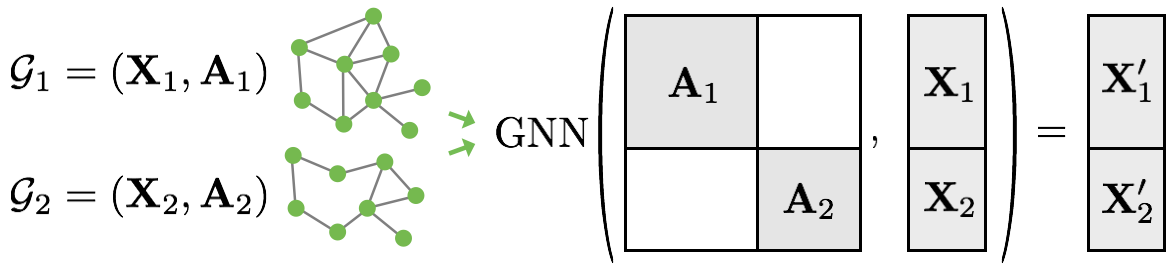

_Block matrix representation for two graphs. (Image credit, [PyG documentation](https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing#scrollTo=mHSP6-RBOqCE))_

Fortunately, PyG handles this batching procedure for us in the [torch_geometric.loader.DataLoader](https://pytorch-geometric.readthedocs.io/en/latest/modules/loader.html#torch_geometric.loader.DataLoader) class.

Let's look at some batches for our the Mutagenicity dataset.

In [ ]:
loader = DataLoader(dataset, batch_size=32, shuffle=True)

cnt = 0
max_cnt = 3
for step, data in enumerate(loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()
    cnt += 1
    if cnt == max_cnt:
        break

Note that the dataloader provides a `DataBatch` object representing each batch. In each batch, we can immediately see that the number of samples (batch size) is 32. This is reflected also in the structure of the data where we see that the target data `y` has 32 entries. 

We also see that the node feature data, `x` has been stacked into a single 2D matrix. Later, we will want to aggregate the tensors representing the nodes of an individual graph to create an overall graph representation for classification. To support this, the `DataBatch` object also includes a `batch` tensor which contains the graph index corresponding to the node index in `x` for each node, i.e., `batch[i]=j` implies that the node with index `i` in `x` belongs to graph `j`. The `ptr` tensor contains a monotonically increasing list of integers that represent the node indicies corresponding to each graph, i.e., for the first graph in the batch, the nodes of that graph have indicies in `x` that span `range(ptr[0],ptr[1])`.

## Data Module
As in the previous practicums, we will utilize PyTorch Lightning to simplify model development. As a first step, we will create a `DataModule` to manage our training, validation, and test data splits as well has constructing our data loaders. Here, we specifically build a DataModule to handle TUDatasets.

In [ ]:
class TUDataModule(L.LightningDataModule):
    def __init__(self, dataset_name, batch_size=32, test_fraction = 0.2, val_fraction = 0.1, shuffle = True,
                 class_name_map = None):
        super().__init__()
        self.dataset_name = dataset_name
        self.batch_size = batch_size
        self.test_fraction = test_fraction
        self.val_fraction = val_fraction
        self.class_name_map = class_name_map
        self.num_classes = None
        self.shuffle = shuffle

    def setup(self, stage=None):
        self.dataset = TUDataset(root='data/TUDataset', name=self.dataset_name)
        self.num_classes = self.dataset.num_classes
        self.num_features = self.dataset.num_features

        test_size = int(len(self.dataset) * self.test_fraction)
        train_size = len(self.dataset) - test_size
        val_size = int(train_size * self.val_fraction)
        train_size = len(self.dataset) - test_size - val_size

        train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
            self.dataset, [train_size, val_size, test_size])
        
        self._train_dataloader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        self._val_dataloader = DataLoader(val_dataset, batch_size=self.batch_size,)
        self._test_dataloader = DataLoader(test_dataset, batch_size=self.batch_size)

    def train_dataloader(self):
        return self._train_dataloader

    def test_dataloader(self):
        return self._test_dataloader
    
    def val_dataloader(self):
        return self._val_dataloader


Let's make sure our data module works as expected.

In [ ]:
dm = TUDataModule('Mutagenicity', batch_size=32, class_name_map={0: 'Mutagenic', 1: 'Non-mutagenic'})
dm.setup()
loader = dm.train_dataloader()

cnt = 0
max_cnt = 2
for step, data in enumerate(loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()
    cnt += 1
    if cnt == max_cnt:
        break


# Mutagenicity Prediction Model

Let's now build our first graph neural network. We will begin with a model that classifies an input graph representation of a molecule as mutagentic or not mutagenic. Mutagenic molecules are ones capable of cauing permanent changes in the genetic makeup of an organism, either by altering the structure of genetic material or the amount of genetic material. Such mutations may cause disease (e.g., cancer).

We saw earlier that each node in the molecule's graph representation has a 14-dimensional feature vector. This vector is a one-hot encoding of the atom represented by the node:

| Index | Atom |
|-------|------|
| 0     | C    |
| 1     | O    |
| 2     | Cl   |
| 3     | H    |
| 4     | N    |
| 5     | F    |
| 6     | Br   |
| 7     | S    |
| 8     | P    |
| 9     | I    |
| 10    | Na    |
| 11    | K    |
| 12    | Li    |
| 13    | Ca    |


## Encoder
As in our previous practicums, we will adopt an _enocder - classifier_ paradigm for graph classifcation. Our encoder will use graph convolutional layers that we discussed in the last lecture. We'll create these using the PyG [conv.GCNConv class](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html#torch_geometric.nn.conv.GCNConv). During training, the weights in these layers will be updated so as to create node representations that capture useful information about the node feature (atomic type) and its relation with its neighbors (which other atoms and in which configurations) for mutigen classificaiton. We will apply the `ReLU` activation to the output of each graph convolution layer.

In this implementaiton, we include 2 `GCNConv` layers which will allow the representation of a given node to include information from neighbors up to 2 hops away. 

In [ ]:
class GCNEncoder2Layer(nn.Module):
    def __init__(self, node_feature_dim, hidden_channels):
        super().__init__()
        self.gcn1 = GCNConv(node_feature_dim, hidden_channels)
        self.gcn2 = GCNConv(hidden_channels, hidden_channels)


    def forward(self, x, edge_index):
        x = self.gcn1(x, edge_index)
        x = x.relu()
        x = self.gcn2(x, edge_index)
        x = x.relu()
        return x

# Test the ImageEncoder with random input data
encoder = GCNEncoder2Layer(dm.num_features, 32)
sample_batch = next(iter(dm.train_dataloader()))
print("input shape",sample_batch)
encoder_output = encoder(sample_batch.x, sample_batch.edge_index)
print("Output shape:", encoder_output.shape)

# Problem 1 (2 points)
Update the GCNEncoder module to allow for an arbitrary number of graph convolution layers specified by the input argument `num_gc_layers`. Assume the same number of output channels (specified by `hidden_channels`) for all layers. HINT: Add the layers to the `ModuleList` in the `self.hidden_layers` variable. Addtionally, each layer should be followed by a rectified linear activation. Test your encoder using 3 graph convolution layers.

In [ ]:
class GCNEncoder(nn.Module):
    def __init__(self, node_feature_dim, num_gc_layers, hidden_channels):
        super().__init__()
        self.hidden_layers = nn.ModuleList()
        
        ################ START YOUR CODE HERE ################


        ################ END YOUR CODE HERE ################

    def forward(self, x, edge_index, batch):
        ################ START YOUR CODE HERE ################
        pass

        ################ END YOUR CODE HERE ################

# Create an instance of your encoder with 3 graph convolution layers
encoder = None

# Test the encoder
sample_batch = next(iter(dm.train_dataloader()))
print("input shape",sample_batch)
encoder_output = encoder(sample_batch.x, sample_batch.edge_index)
print("Output shape:", encoder_output.shape)

## Classifier
We are now ready to create the classifier module for our _encoder - classifier_ model. Unlike our previous models, we need to peform an extra step before passing the encoder output to a linear layer for classification. Specifically, we need to aggregate the node representations (i.e., embeddings) generated by the encoder to form an overall representation of the graph. This overall representation is often referred to as a __readout layer__ in the literature. Different types of readout layers are implemented in PyG in the [pooling layers module](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#pooling-layers). We will use the [torch_geometric.nn.global_mean_pool](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.pool.global_mean_pool.html#torch_geometric.nn.pool.global_mean_pool) readout layer. This method creates the representation $R_G$ of a graph $G$ through the average latent representation of its $N$ nodes:
$$R_G = \frac{1}{N}\sum_{n=1}^{N}\bf{x}_n$$

where $\bf{x}_n$ is the latent representation of node $n$.

In [ ]:
class Classifier(nn.Module):
    def __init__(self, latent_dim, num_classes):
        super().__init__()
        self.linear = nn.Linear(latent_dim, num_classes)  

    def forward(self, x, batch):
        # pass the encoder output through the readout layer
        x = global_mean_pool(x, batch) # batch size x latent_dim
        x = F.dropout(x, p=0.5, training=self.training) # include dropuout regularization
        x = self.linear(x) # pass through the linear layer for logits
        return x

# Test the module with random input data
classifier = Classifier(32,dm.num_classes)
classifier_output = classifier(encoder_output, sample_batch.batch)
print("Output shape:", classifier_output.shape)  # Expected output shape: [5, 10]

## Mutagenicity Model
With the encoder and classifier modules developed, we are now ready to create our overall classificaiton model. Following the previous practicums, we will leverage the PyTorch LightningModule class to create the model. This model class has the same structure as the LightningModule classes we've seen previously. However, notice that the `databatch` passed to the `forward`, `training_step`, `validation_step` and `test_step` require different handling than the `batch` object that was used in our previous models.

In [ ]:
class MolecularGraphClassifierModel(L.LightningModule):
    def __init__(self, encoder, classifier, num_classes):
        super().__init__()
        # model layers
        self.encoder = encoder
        self.classifier = classifier
        
        # validation metrics
        self.val_metrics_tracker = TM.wrappers.MetricTracker(TM.MetricCollection([TM.classification.MulticlassAccuracy(num_classes=num_classes)]))
        self.validation_step_outputs = []
        self.validation_step_targets = []

        # test metrics
        self.test_roc = TM.ROC(task="multiclass", num_classes=num_classes, thresholds=list(np.linspace(0.0, 1.0, 20))) # roc and cm have methods we want to call so store them in a variable
        self.test_cm = TM.ConfusionMatrix(task='multiclass', num_classes=num_classes)
        self.test_metrics_tracker = TM.wrappers.MetricTracker(TM.MetricCollection([TM.classification.MulticlassAccuracy(num_classes=num_classes), 
                                                            self.test_roc, self.test_cm]))
        self.test_step_outputs = []
        self.test_step_targets = []

    def forward(self, databatch):
        # NOTE: the databatch is a PyG databatch object
        x = databatch.x
        edge_index = databatch.edge_index
        batch = databatch.batch
        x = self.encoder(x, edge_index)
        x = self.classifier(x, batch)
        return x

    def training_step(self, databatch, batch_idx):
        y = databatch.y
        logits = self.forward(databatch)
        loss = nn.functional.cross_entropy(logits, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, databatch, batch_idx):
        y = databatch.y
        logits = self.forward(databatch)
        loss = nn.functional.cross_entropy(logits, y)
        self.log('val_loss', loss, on_step=True, on_epoch=True)
        
        # store the outputs and targets for the epoch end step
        self.validation_step_outputs.append(logits)
        self.validation_step_targets.append(y)
        return loss
    
    def on_validation_epoch_end(self):
        # stack all the outputs and targets into a single tensor
        all_preds = torch.vstack(self.validation_step_outputs)
        all_targets = torch.hstack(self.validation_step_targets)
        
        # compute the metrics
        loss = nn.functional.cross_entropy(all_preds, all_targets)
        self.val_metrics_tracker.increment()
        self.val_metrics_tracker.update(all_preds, all_targets)
        self.log('val_loss_epoch_end', loss)
        
        # clear the validation step outputs
        self.validation_step_outputs.clear()
        self.validation_step_targets.clear()
    
    def test_step(self, databatch, batch_idx):
        y = databatch.y
        logits = self.forward(databatch)
        loss = nn.functional.cross_entropy(logits, y)
        self.log('test_loss', loss, on_step=True, on_epoch=True)
        self.test_step_outputs.append(logits)
        self.test_step_targets.append(y)
        return loss
    
    def on_test_epoch_end(self):
        all_preds = torch.vstack(self.test_step_outputs)
        all_targets = torch.hstack(self.test_step_targets)
        
        self.test_metrics_tracker.increment()
        self.test_metrics_tracker.update(all_preds, all_targets)
        # clear the test step outputs
        self.test_step_outputs.clear()
        self.test_step_targets.clear()

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

We are now ready to train our model. Let's reload our data to make sure the random state is reset.

In [ ]:
seed_everything(rs)
dm = TUDataModule('Mutagenicity', batch_size=32, class_name_map={0: 'Mutagenic', 1: 'Non-mutagenic'})
dm.setup()

In [ ]:
seed_everything(rs)
encoder = encoder = GCNEncoder(dm.num_features, 3, 32)
classifier = classifier = Classifier(32,dm.num_classes)
mutagenicity_model = MolecularGraphClassifierModel(encoder, classifier, num_classes=dm.num_classes)

trainer = L.Trainer(default_root_dir=dir_lightning, 
                    max_epochs=50,
                    callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=5)])
trainer.fit(model=mutagenicity_model, train_dataloaders=dm.train_dataloader(), val_dataloaders=dm.val_dataloader())

## Validation Set Accuracy

In [ ]:
mca = mutagenicity_model.val_metrics_tracker.compute_all()['MulticlassAccuracy']
plt.plot(range(1, len(mca)+1), mca, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Epoch Validation Accuracy')
plt.grid()

# Test Set Performance
Now that we've trained the model, we're ready to examine the test set accuracy. Here, we use the PyTorch Lightning Trainer module's _test_ function passing in the test dataloader from our datamodule.

In [ ]:
trainer.test(model=mutagenicity_model, dataloaders=dm.test_dataloader())

Next, we gather the performance metrics from the model's `test_metrics_tracker` attribute using the `compute` method. Then we can print the classification reprot and plot the confusion matrix and the class level ROC curves to assess performance.

In [ ]:

model = mutagenicity_model

rslt = model.test_metrics_tracker.compute()
# Print the classification report
device = torch.device("cpu")   #"cuda:0"
model.eval()
y_true=[]
y_pred=[]
with torch.no_grad():
    for databatch in dm.test_dataloader():
        y = databatch.y
        pred = model(databatch).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(y[i].item())
            y_pred.append(pred[i].item())

print(classification_report(y_true,y_pred,target_names=list(dm.class_name_map.values()),digits=4))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

cmp = sns.heatmap(rslt['MulticlassConfusionMatrix'], annot=True, fmt='d', cmap='Blues', ax=axes[0])
cmp.set_xlabel('Predicted Label')
cmp.set_xticklabels(dm.class_name_map.values(), rotation=0)
cmp.set_yticklabels(dm.class_name_map.values(), rotation=0)
cmp.set_ylabel('Actual Label');

fpr, tpr, thresholds = rslt['MulticlassROC']
for i in range(len(dm.class_name_map)):
    axes[1].plot(fpr[i], tpr[i], label=dm.class_name_map[i])
plt.xlabel('False Positive Rate')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()

# Protein Classification.
Now let's consider more complex graphs, specifically those representing proteins. Unlike the small molecules represented in the Mutagenicity dataset that contain relatively few atoms, proteins can be much larger. Rather than model the proteins directly by atoms, it is common to represent each node as an amino acid (the building blocks of proteins).

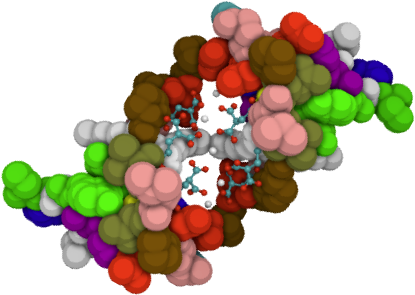

Here we consider the D&D dataset (named for its authors, Dobson and Doig). The dataset contains 1178 protein structures. Each protein is represented by a graph in which the nodes are amino acids and two nodes are connected by an edge if they are less than 6 Angstroms apart. As we can see below, these biomolecules contain many more node (amino acids) than there were in the previous dataset. Next, we will develop a prediction model to classify the protein structures into enzymes and non-enzymes. 

In [ ]:
# Proteins Classification
dataset = TUDataset(root='data/TUDataset', name='DD')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

node_sum = 0
edge_sum = 0
degree_sum = 0

for data in dataset:
    node_sum += data.num_nodes
    edge_sum += data.num_edges
    degree_sum += data.num_edges / data.num_nodes

print(f'Average number of nodes: {node_sum / len(dataset):.2f}')
print(f'Average number of edges: {edge_sum / len(dataset):.2f}')
print(f'Average node degree: {degree_sum / len(dataset):.2f}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

# Problem 2 (1 point)
In the code cell below, use the `TUDataModule` class to create a DataModule to handle the `DD` data. The arguments to the `TUDataModule` constructur should be
- __dataset_name__ = 'DD'
- __batch_size__ = 32
- __class_map_name__ = {0: 'Enzyme', 1: 'Non-enzyme'}

In [ ]:
################ START YOUR CODE HERE ################
dm = None
################ END YOUR CODE HERE ################

dm.setup()

# Problem 3 (2 points)
In the code cell below, use `GCNEncoder`, `Classifer` and `MolecularGraphCalssifierModel` classes to implement a graph nueral network to classify the proteins in the `DD` dataset. For the `GCNEncoder` set 
- __num_gc_layers__ = 4 You can try different values to see if allowing messages from further neighbors improves model performance. 
- __hidden_channels__ = `hidden_dim` 

For the `Classifier`, set
- __latent_dim__ = `hidden_dim`
- __num_classes__ = `dm.num_classes`.

In [ ]:
seed_everything(rs)
hidden_dim = 32

################ START YOUR CODE HERE ################
encoder = None
classifier = None
protein_model = None
################ END YOUR CODE HERE ################

trainer = L.Trainer(default_root_dir=dir_lightning, 
                    max_epochs=50,
                    callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=5)])
trainer.fit(model=protein_model, train_dataloaders=dm.train_dataloader(), val_dataloaders=dm.val_dataloader())

## Validation Set Accuracy

In [ ]:
mca = protein_model.val_metrics_tracker.compute_all()['MulticlassAccuracy']
plt.plot(range(1, len(mca)+1), mca, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Epoch Validation Accuracy')
plt.grid()

# Test Set Performance

In [ ]:
trainer.test(model=protein_model, dataloaders=dm.test_dataloader())

# Problem 4 (1 point)

In the code cell below, print the _classification report_ and plot the _confusion matrix_ and _ROC_ curves to analyze the test set performance of the protein enzyme classification model, `protein_model`.

In [ ]:
model = protein_model

rslt = model.test_metrics_tracker.compute()

################ START YOUR CODE HERE ################


################ END YOUR CODE HERE ################